In [1]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#modules to find path of all sessions
import glob
import os
import numpy as np
import pickle
import platform
import math
from IPython.display import clear_output, display, HTML
from matplotlib.patches import Rectangle
from matplotlib import collections  as mc
import matplotlib.gridspec as gridspec
from scipy.ndimage.filters import gaussian_filter as smooth
import matplotlib
from __future__ import print_function
np.set_printoptions(precision=3, suppress=True)
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import ranksums as WilcoXon


import warnings
warnings.filterwarnings('ignore')

### you might need to change the line below if you want to regenerate the figure on a differente computer 
### Below we will run some preprocessing notebooks. In our case, our preprocessing notebooks are located in 
### a folder ("load_preprocess_mouse") which is at the same level that the folder that contain the notebooks 
### that generate the figures (for instance this one)


notebookPath=os.path.dirname(os.path.realpath("__file__"))
pathToProcessingNotebooks=os.path.join(os.path.split(notebookPath)[0],"load_preprocess_mouse")
os.chdir(pathToProcessingNotebooks)   
%run loadMouse_documentation.ipynb
%run loadRawSpike_documentation.ipynb
%run plotMouse_Behavior.ipynb


#######

def has_tag(root, animal, session, tagList):
    """ Test if the session has at least one of the tag in tagList
    tag = empty file with a specific name, in a session folder
    """
    fullPath = os.path.join(root, animal, "Experiments", session)
    fileList = os.listdir(fullPath)
    for tag in tagList:
        if tag in fileList:
            return True
    return False

def cm2inch(value):
    return value/2.54
    

#Those parameters are overwritten if there is a .behav_param file
paramCarola={
    "distanceToRun":100,
    "maxTrialDuration": 60,
    "valveONTime":50,
    "minInterTrialDuration":15,
    "immobilityDuration":2,
    #to read .eeg (put None to not read .eeg)
    "nChannelElectro":32, #32
    "channel_opto": -6, #not used
    "channel_lickBreak":-5,
    "channel_reward": -4, #not used currently
    "channel_sound": -3, #not used
    "channel_trialON": -2,
    "channel_beamBreak": -1,
}    


#### root is the path to the folder where the data (MOUXXX, MOUXXY, ....ALLMOU_Analysis) are located
### you might need to change the line below depending on your computer orgnization 



if platform.system()=='Linux':
    root="/data"
else:
    root="/Users/davidrobbe/Documents/Data/"
    
    
# Where to Save Files

savePath=os.path.join(root,"ALLMOU_Analysis","FigForMS")
    
print("path to data is %s"%root)
print("")
print("importing done")

ERROR: File `'plotMouse_SpikingActvity.ipynb.py'` not found.


path to data is /data

importing done


In [2]:
%run plotMouse_SpikingActivity.ipynb

## Part I: For all the cells accross good sessions compute meanfiringrate during runs and find significant modulation portion
## <span style="color:red">Take ~ 10 min to run!</span> No need to rerun it each time: output are saved in pickle files

In [ ]:
animalList = [os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]

#Whether to read the existing pickle files (redo=False) or to reload from raw text files (redo=True)
redo = False
###############################
redo = False
###############################
#Wheter to run some batch on electrophy data
runElectrophyBatch=True
###############################
runElectrophyBatch=True
###############################
#list of tags (tag = empty file in the session folder with a specific name)
#leave empty for no tag
tagList = ["GoodPerfo"]
###############################

###############################

#---------------------------------------------------------------------------
print("List of animal to loop through: %s" % animalList)
print("Tag list: %s" % tagList)

#loop on animal
animalindex=1
for animal in animalList:
    print("Animal %s"%animal)
    print("%s out of %s" %(animalindex,len(animalList)))
    print("**********")
    animalindex += 1
    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)
    nbSession=len(sessionList)
    
    
    
    #loop through sessions
    for index, session in enumerate(sessionList):
        
        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
        
        #print("Session %s/%s: %s"%(index+1,nbSession,session))
        #load data for this session (add redoPreprocess=True to overwrite preprocess)
        
        sessionData=Data(root, animal, session, param=param, redoPreprocess=redo)
            

        
        if runElectrophyBatch:


            print("Session %s is beeing analyzed with  GetAllSignificantModulation function"%session)
            GetAllSignificantModulation(sessionData,redo=True,saveAsPickle=True,excludeDrift=True,behaviorType=["Runs","all"])


clear_output()
print("Done")


## Part II: Calculate the mean duration of the run epochs for all the units accross sessions to normalize run duration accross session


In [3]:
behaviorType=["Runs","all"]
tagList = ["GoodPerfo"]
targetStrings=["positive","negative"]
#list of all animals
animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]


### loop throught the session to find the length of average firing rate for the different sessions


averageRunDurationAccrossAllUnits=[]




#loop on animal
for animal in animalList:

    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)   

    #loop through sessions and load pickle file
    for index,session in enumerate(sessionList):


        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
                           
        
        
        analysisPath=os.path.join(root,animal,"Experiments",session,"Analysis")
        picklePath=os.path.join(analysisPath,"ModulationDuring" + behaviorType[1].replace(" ","") + behaviorType[0] + ".p")
        firingRatesModulation=pickle.load(open(picklePath,"rb"))
        
        
        for shank in firingRatesModulation["MeanFiringRateZscored"]:
            for cluster in firingRatesModulation["MeanFiringRateZscored"][shank]:
                if firingRatesModulation["BiggestModulationSign"][shank][cluster] in targetStrings:
                    averageRunDurationAccrossAllUnits.append(len(firingRatesModulation["insideBehaviorIndexes"][shank][cluster]))
                    
nSideBin=firingRatesModulation["insideBehaviorIndexes"][shank][cluster][0]
medianAverageRunDurationAccrossAllUnits=np.median(averageRunDurationAccrossAllUnits)
print("number of units %s" %(len(averageRunDurationAccrossAllUnits)))
print("median duration of runs %s" %medianAverageRunDurationAccrossAllUnits)


number of units 146
median duration of runs 28.0


## Part III:  ReNormalize Firing rate in the time domain (versus median run duration)

### Can select units that have been determined to have a postive or negative modulation during run using the function GetModulatedPortionsDuringRun
(This code is Modified from an orginal version below.june 2016)

In [4]:
def normalizeFiringRateInTime(thisFiringRateModulation,insideRunBins,medianAverageRunDurationAccrossAllUnits,signifiantModulationIndexes):
    
    meanFiringRateInRun=thisFiringRateModulation[insideRunBins]
    runIndexes=range(len(meanFiringRateInRun))
    runIndexesInterp=np.arange(0,float(runIndexes[-1])+float(runIndexes[-1])/float(medianAverageRunDurationAccrossAllUnits-1),float(runIndexes[-1])/float(medianAverageRunDurationAccrossAllUnits-1))
    if len(runIndexesInterp)>medianAverageRunDurationAccrossAllUnits:
        runIndexesInterp=np.asarray([x for x in runIndexesInterp if x <= float(runIndexes[-1])])

    # do the itnerpolation
    meanFiringRateInRunNorm=np.interp(runIndexesInterp,runIndexes,meanFiringRateInRun)
    # reconcatenate the borders
    normFiringRateInRun=np.concatenate([thisFiringRateModulation[0:insideRunBins[0]],meanFiringRateInRunNorm,thisFiringRateModulation[insideRunBins[-1]+1:]],axis=0)

    
    # find the significant modulation on time normalized data
    allIndexes=list(range(len(thisFiringRateModulation)));
    allIndexesInterpt=np.concatenate([allIndexes[:insideRunBins[0]],runIndexesInterp+insideRunBins[0],allIndexes[-insideRunBins[0]:]],axis=0)
    
    #Get the border of the modulation
    borders=contiguous_regions(np.asarray([X in signifiantModulationIndexes for X in allIndexes])).tolist()
    interpolatedSignificantIndexes=[]
    for startstop in borders:
        interpolatedSignificantIndexes.append([index for index,value in enumerate(allIndexesInterpt) if (value>=startstop[0] and value<=startstop[1])])
    
    return normFiringRateInRun,interpolatedSignificantIndexes
    
    
    
    

# loop across data to normalize length of mean firing rate across session
# keep cells that have a modulation sign according to TargetString

#animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]
tagList = ["GoodPerfo"]
targetStrings=["positive","negative"]
allFiringRates=[]
nberOfPositivelyModulatedCells=0
nberOfNegativelyModulatedCells=0
for animal in animalList:


    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)
    
  

    #loop through sessions
    for index,session in enumerate(sessionList):
        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
                
        analysisPath=os.path.join(root,animal,"Experiments",session,"Analysis")
        picklePath=os.path.join(analysisPath,"ModulationDuring" + behaviorType[1].replace(" ","") + behaviorType[0] + ".p")
        if os.path.exists(picklePath):
            #print(picklePath)
            firingRatesModulation=pickle.load(open(picklePath,"rb"))
            
            for shank in firingRatesModulation["MeanFiringRate"]:
                for cluster in firingRatesModulation["MeanFiringRate"][shank]:
                    if firingRatesModulation["BiggestModulationSign"][shank][cluster] in targetStrings:
                        insideRunBins=firingRatesModulation['insideBehaviorIndexes'][shank][cluster]
                        thisFiringRateModulation=firingRatesModulation["MeanFiringRate"][shank][cluster]
                        signifiantModulationIndexes=firingRatesModulation["AllSignificantModulationIndexInBehaviorSameSignThanBiggest"][shank][cluster]
                        normFiringRateInRun,interpolatedSignificantIndexes=normalizeFiringRateInTime(thisFiringRateModulation,insideRunBins,medianAverageRunDurationAccrossAllUnits,signifiantModulationIndexes)
                           
                        
                        #find max or min and append main variables in a big list
                        if firingRatesModulation["BiggestModulationSign"][shank][cluster]=='positive':
                            strongestModulationIndex=np.argmax(normFiringRateInRun)
                            nberOfPositivelyModulatedCells+=1

                        elif firingRatesModulation["BiggestModulationSign"][shank][cluster]=='negative':
                            strongestModulationIndex=np.argmin(normFiringRateInRun)
                            nberOfNegativelyModulatedCells+=1
                            
                        allFiringRates.append([strongestModulationIndex,normFiringRateInRun,interpolatedSignificantIndexes,session,shank,cluster,firingRatesModulation["BiggestModulationSign"][shank][cluster]])

firingRatesAs2DArray=np.asarray([item[1] for item in allFiringRates])
normFiringRatesAs2DArray=np.asarray([item[1]/max(item[1]) for item in allFiringRates])

# generate an array with just the significative positive modulation

allFiringRatesPositiveModulation=[firingRate for firingRate in allFiringRates if firingRate[-1]=='positive']
timeSortedFiringRatesPositiveModulation=sorted(allFiringRatesPositiveModulation, key=lambda firingdata: firingdata[0])
#timeSortedFiringRatesAs2DArrayPositiveModulation=np.asarray([item[1] for item in timeSortedFiringRatesPositiveModulation])
nonSortedFiringRatesAs2DArrayPositiveModulation=np.asarray([item[1] for item in allFiringRatesPositiveModulation])

# Functions for PCA, polynome fit, classification

In [5]:
def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))
#-------------------------------------------------
def plot_principal_components(tuningDict,nc,colors):
    '''
    tuningDict = dict of normalized mean firing rates
    nc = number of component to consider in PCA
    '''
    q = tuningDict
    nbins = len(q[0])
    from sklearn.decomposition.pca import PCA
    q=np.array(list(q.values()))
    for i in range(len(q)):
        q[i,:]=normalize(q[i,:])
    pca1 = PCA(n_components=nc)
    pca1.fit(q)
    print("n=2, explained variance: ",np.sum(pca1.explained_variance_ratio_)) 
    for i in range(nc):
        v=pca1.components_[i]
        plt.plot(v,colors[i], label="c "+np.str(i+1))

    #plt.plot(v2,"g--")
    ax = plt.gca()
    ax.set_xticks([0,nbins-1],["Beg","End"])
    ax.set_xlim(0,nbins-1)
    ax.set_xlabel("Run phase",fontsize=12)
    ax.set_ylabel("Loading",fontsize=12)
    #plt.legend(loc="best",fontsize=8)
    #plt.plot(v2,"gray")
    #plt.yticks(np.arange(-0.3,0.4,0.1))
    print(len(v))
#-----------------------------------------------------------
def quadraticFit_stats(tuning_clu):
    nbins=len(tuning_clu)
    xdata = np.arange(nbins)
    #As an added benefit centering the x variable reduces the correlation between the linear and quadratic terms.
    #The correlation between x and x2 is 0.975 while the correlation between c and c2 is 0.000.==>
    xdata=xdata-np.mean(xdata)
    ydata=normalize(tuning_clu)
    d={'x':xdata,"y":ydata}
    model = smf.ols(formula = 'y ~ np.power(x,2)+x',data=d).fit()
    b,a,pb,pa=model.params["x"],model.params['np.power(x, 2)'],model.pvalues["x"],model.pvalues['np.power(x, 2)']
    c = model.params["Intercept"]
    return [a,b,pa<=0.05,pb<=0.05,c]
#--------------------------------------------------------------
def test_quadraticVslinear(a,b,c,pa,pb,x):
        y=a*x*x+b*x+c
        if pa and (not pb):
            if a>0 :#and np.abs(b/(-2*a))<1:
                    test="QuadraticConvexe"
            else:
                    test="QuadraticConcave"
        #elif  pb and (not pa):
        #    if b>0:
        #       test="Increasing"
        #    else:
        #        test="Decreasing"
        elif pb:#elif pb and pa:      
            if a>0:
                if y[0]<y[-1]:
                    test="QuadraticConvexeUp"
                else:
                    test="QuadraticConvexeDown"
            else:
                if y[0]>y[-1]:
                    test="QuadraticConcaveDown"
                else:
                    test="QuadraticConcaveUp"
        else:
            test="none"
        return test,y
#---------------------------------------------------
def classify_cells(clu_quadraticFit,xdata):
    #increasing =[]
    #decreasing =[]
    onset=[]
    offset=[]
    negOnset=[]
    negOffset=[]
    duration=[]
    onoff=[]
    none=[]
    for c in clu_quadraticFit:
        a,b,pa,pb,intercept=clu_quadraticFit[c]
        test,y=test_quadraticVslinear(a,b,intercept,pa,pb,xdata)
        if test=="QuadraticConcave":duration=np.append(duration,c)
        elif test=="QuadraticConcaveUp":negOffset=np.append(negOffset,c)
        elif test=="QuadraticConvexeUp":offset=np.append(offset,c) 
        elif test=="QuadraticConcaveDown":negOnset=np.append(negOnset,c) 
        elif test=="QuadraticConvexeDown":onset=np.append(onset,c)
        elif test=="QuadraticConvexe":onoff=np.append(onoff,c)
        else:none=np.append(none,c)
    #return onset,negOffset,offset,negOnset,onoff,duration,none
    return onoff,onset,negOnset,duration,negOffset,offset,none

def FindCellIndexInGroups(CellIndex,Groups):
    for index,CellIDs in enumerate(Groups):
        if CellIndex in CellIDs:
            return(index)
        
def plot_figureClasses(X,clu_quadraticFit_WT,xdata,nSideBin):
    from matplotlib.patches import Rectangle
   
    plt.imshow(X,interpolation="bilinear",aspect="auto",origin="low",cmap="Reds")
    ax = plt.gca()
    ax.tick_params(axis='both',which='major',width=2)
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    #ax.spines['bottom'].set_color("none")
    ax.yaxis.set_ticks_position('left')
    #ax.xaxis.set_ticks_position('none')
    ax.set_xticks([nSideBin,X.shape[1]/2,X.shape[1]-nSideBin])
    ax.get_xaxis().set_tick_params(direction='out')
    ax.get_yaxis().set_tick_params(direction='out')
    ax.axvline(nSideBin,color="orange",linestyle='--',linewidth=3)
    ax.axvline( X.shape[1]-nSideBin,color="orange",linestyle='--',linewidth=3)
    
    
    ax.set_xlabel("Run Phase",fontsize=12)
    ax.set_xticklabels(["start","","end"])
    ax.set_yticks(np.arange(0,len(clu_quadraticFit_WT),20))
    ax.set_ylabel('Cells + (sorted)',fontsize=12)
    names=["On/off","Onset(+)","Onset(-)","Duration",
           "Offset(-)","Offset(+)","Other"]
    colors=["goldenrod","darkgreen","lightgreen","brown","lightblue","darkblue","gray"]
    s0=0
    s1=0
    #plt.plot([53,55],[s0,s0],"k")
    cpt=0
    for i in classify_cells(clu_quadraticFit_WT,xdata):
        s0=s1
        s1+=(len(i))
        pad=-1
        colorbarsize=2
        plt.plot([X.shape[1]+pad,X.shape[1]+pad],[s0,s1],"w")
        ax.add_patch(Rectangle((X.shape[1]+pad, s0), colorbarsize, s1-s0, facecolor=colors[cpt]))
        plt.plot([X.shape[1]+pad,X.shape[1]+pad+colorbarsize],[s1,s1],"w")
        plt.text(X.shape[1]+pad+colorbarsize+0.5, s0+(s1-s0)/4., names[cpt], ha='left', va='bottom', rotation=30)
        cpt+=1
    ax.set_ylim(0,s1)
    ax.set_xlabel("Run phase")
    clear_output()
#---------------------------------------------------------------------------------
def illustrate_classes(tuningWithoutBorder,tuningWithBorders,nSideBin,ind,Groups,xdata,plotcellindex=False):
    ydata =tuningWithoutBorder[ind]
    ydatatoplot=normalize(tuningWithBorders[ind])
    n=len(ydata)
    xdata=xdata-np.mean(xdata)
    ydata=normalize(ydata)
    d={'x':xdata,"y":ydata}
    model = smf.ols(formula = 'y ~ np.power(x,2)+x',data=d).fit()
    b,a,pb,pa=model.params["x"],model.params['np.power(x, 2)'],model.pvalues["x"],model.pvalues['np.power(x, 2)']
    #print("b=%s,a=%s,pb=%s,pa=%s" %(b,a,pb,pa))
    c = model.params["Intercept"]
    ax=plt.gca()
    ax.set_xlabel("Run phase",fontsize=12)
    ax.set_ylabel("Normalized \n firing rate",fontsize=12)
    xaxis=np.arange(nSideBin,nSideBin+len(ydata))
    #plt.plot(xaxis,model.predict(),"c",lw=4)
    ax.set_xticks([nSideBin,nSideBin+len(ydata)],["start","end"])
    #plt.xlim(0,n-1)
    ax.set_ylim(0,1.1)
    ax.set_yticks([0,1],["min","max"])
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    #plt.fill_between(np.arange(len(ydatatoplot)),np.zeros(len(ydatatoplot)),ydatatoplot,color=colorfill)
    ax.axvspan(nSideBin, nSideBin+len(ydata), facecolor="orange",edgecolor="none",alpha=0.5)
    ax.plot(ydatatoplot,color='red',linewidth=2,alpha=0.5)
    
    names=["On/off","Onset(+)","Onset(-)","Duration","Offset(-)","Offset(+)","Other"]
    colors=["goldenrod","darkgreen","lightgreen","brown","lightblue","darkblue","gray"]
    groupIndex=FindCellIndexInGroups(ind,Groups)
    ax.plot(xaxis,model.predict(),color=colors[groupIndex],lw=4,linestyle='--')
    #plt.title(names[groupIndex]+ " cell id= %s" %ind,color=colors[groupIndex])
    if plotcellindex:
        titleName=names[groupIndex]+ " cell id= %s" %ind        
    else:
        titleName=names[groupIndex]
        
    ax.set_title(titleName,color=colors[groupIndex],fontweight='bold')
    #print(test_quadraticVslinear(a,b,0,pa,pb,xdata)[0])


    
    #clear_output()


# Results PCA Fits ...

In [6]:
# We work with the positively modulated cells. We work on the non-sorted array of all units  for the latter visualisation purpose of the classes

alltuningMiceWithBorders = nonSortedFiringRatesAs2DArrayPositiveModulation
nCells =alltuningMiceWithBorders.shape[0]
#np.random.shuffle(alltuningMiceWithBorders)
tuningWithBorders={}
for clu in np.arange(nCells):
    tuningWithBorders[clu] = alltuningMiceWithBorders[clu,:]


# Then we run the quadratic decomposition using the tuning curve without the pre and post run epochs


alltuningMiceWithoutBorder=alltuningMiceWithBorders[:,nSideBin:-nSideBin]
tuningWithoutBorder={}
for clu in np.arange(nCells):
    tuningWithoutBorder[clu] = alltuningMiceWithoutBorder[clu,:]

nBins=len(tuningWithoutBorder[clu] )
xdata = np.arange(0,nBins,1)
xdata = xdata -np.mean(xdata)

clu_quadraticFit={}
for clu in tuningWithoutBorder:
        clu_quadraticFit[clu]=quadraticFit_stats(tuningWithoutBorder[clu])

### the code below return A wich give the composition of the different groups 
#### (each unit is labeled according to its position in the array NonSortedFiringRatesAs2DArrayPositiveModulation)

In [7]:
#classify the tuning using the modulation restricted to the run (not before and after)-
A = list(classify_cells(clu_quadraticFit,xdata))
#------------------------------------------------

## reconstruct a maxtrix X based on the classification. But  we do not use the entire tuning that is : it contains immobility before and after

X=np.zeros((nCells,alltuningMiceWithBorders.shape[1]))
cpt=0
for i in range(len(A)):
    if len(A[i])>0:
        for c in A[i]:
            X[cpt,:]=normalize(tuningWithBorders[c])
            cpt+=1

In [8]:
def plotallcells(sortedNormFiringRatesAs2DArray,nSideBin=12,showXlabel=True,yLabel="Units",matriceColor="Reds",postionXlabel='top'):
    
    
    plt.imshow(sortedNormFiringRatesAs2DArray,interpolation="bilinear",aspect="auto",origin="low",cmap=matriceColor)
    
    #plt.pcolormesh(timebin,y,sortedNormFiringRatesAs2DArray,cmap="Reds")
    ax = plt.gca()
    #plt.xlim(0,timebin[-1])
    ax.set_ylim([0,sortedNormFiringRatesAs2DArray.shape[0]])
    ax.tick_params(axis='both',which='major',width=2)
    ax.set_ylabel(yLabel,fontsize=12)
    ax.set_yticks(np.arange(0,sortedNormFiringRatesAs2DArray.shape[0],20))
    
    if showXlabel:    
        ax.set_xlabel("Run Phase",fontsize=12)
        ax.set_xticklabels(["start","","end"])
    else:
        ax.set_xticklabels([])
    
    ax.axvline(nSideBin,color="orange",linestyle='--',linewidth=2)
    ax.axvline( sortedNormFiringRatesAs2DArray.shape[1]-nSideBin,color="orange",linestyle='--',linewidth=2)
    #ax = plt.gca()   
    ax.set_xticks([nSideBin,sortedNormFiringRatesAs2DArray.shape[1]/2,sortedNormFiringRatesAs2DArray.shape[1]-nSideBin])
    ax.get_xaxis().set_tick_params(direction='out')
    ax.get_yaxis().set_tick_params(direction='out')
    
    ax.yaxis.set_ticks_position('left')
    #ax.xaxis.tick_top()
    ax.xaxis.set_label_position(postionXlabel)
    if postionXlabel=='top':
        ax.tick_params(labelbottom='off',labeltop='on')
    else:
        ax.tick_params(labelbottom='on',labeltop='off')
def modifyAxesForFig(ax,xlabel,ylabel):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel(xlabel,fontsize=12)
    ax.set_ylabel(ylabel,fontsize=12)
    ax.locator_params(axis='both',nbins=4)
    ax.set_title("")
    
def plot_distribution(rawdata,maxminstep,xyLabels=["N","Bins"]):   
    plt.hist(rawdata,np.arange(maxminstep[0],maxminstep[1]+maxminstep[2],maxminstep[2]),width=maxminstep[2]*0.9,color='k',linewidth=0)
    ax = plt.gca()
    #ax.set_xlim(maxminstep[:2])
    ax.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
    ax.set_xlabel(xyLabels[1],fontsize=12)
    ax.set_ylabel(xyLabels[0],fontsize=12)
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.get_xaxis().set_tick_params(direction='out')
    return ax

## Cell type info in  this analysis

In [9]:
### 1. Load waveform.p to get for a given cluster, waveform caracteristic
def GetHalfWidthPeakToValley(session,shank,cluster):
    waveFormSavedInfoPath=os.path.join(root,session[0:6],"Experiments",session,"Analysis","waveforms.p")
    with open(waveFormSavedInfoPath, 'rb') as f:
        res = pickle.load(f)
        res=res[shank][cluster]
        caracteristics=res[0]
        return caracteristics['HalfWidth'],caracteristics['PeakToValley'],res
    

### 2. load UnitsWaveFormAndFiringRateCharacteristics.p and use waveform value to find firing rate info
#### This works session by session

def GetWaveFormFiringRateParams(session):
    waveFormFRateInfoPath = os.path.join(root,session[0:6],"Experiments",session,"Analysis", "UnitsWaveFormAndFiringRateCharacteristics.p")
    with open(waveFormFRateInfoPath, 'rb') as f:
        allCharacteristics = pickle.load(f)
        return allCharacteristics
    
### allCharacteristics contains : 
# immoFRate
# peakToValley
# asymetrie
# PropISI
# meanFRate
# runFRate
# halfWidth

## small function to test if all the element of a sublist are also in a biger list
def testAllInList(sublist,list):
    for item in sublist:
        if item not in list:
            return False
    return True

## using the full id of the cluster return a parameter of the cluster
### immoFRate, peakToValley, asymetrie, PropISI, meanFRate,runFRate, halfWidth

In [10]:
def GetMatchingFRateParam(session,shank,cluster,fRateParam="meanFRate"):
    halfWidth,peakToValley=GetHalfWidthPeakToValley(session,shank,cluster)[0:2]
    allCharacteristics=GetWaveFormFiringRateParams(session)    
    for index,(i,j) in enumerate(zip(allCharacteristics["HalfWidth"],allCharacteristics["PeakToValley"])):
        if testAllInList([i,j],[halfWidth,peakToValley]):
            return allCharacteristics[fRateParam][index],halfWidth,peakToValley

Striatal cells were further classified as either a putative medium spiny cell (MSN), fast-spiking interneuron
(FSI), or an ‘‘other’’ presumed interneuron (O) based on three distinct clusters
found in a scatter plot of two measurements of the wide-band spike waveform:
(1) the peak width at one-half maximum (FSI: 50–200 ms; MSN: 150–450 ms;
O: 200–300 ms), and (2) the time from peak to valley (FSI: 100–455 ms; MSN:
560–1500 ms; O: 300–550 ms). 

In [11]:
waveFormLimits={"cellType":["FSI","PN"],"halfWidth":[[.050,.200],[.150,.450]],"peakToValley":[[.100,.450],[.560,1.500]]}

In [12]:
def getClassData(session):
    
    paramCarola={
        "distanceToRun":100,
        "maxTrialDuration": 60,
        "valveONTime":50,
        "minInterTrialDuration":15,
        "immobilityDuration":2,
        #to read .eeg (put None to not read .eeg)
        "nChannelElectro":32, #32
        "channel_opto": -6, #not used
        "channel_lickBreak":-5,
        "channel_reward": -4, #not used currently
        "channel_sound": -3, #not used
        "channel_trialON": -2,
        "channel_beamBreak": -1,
    }

    if platform.system()=='Linux':
        root="/data"
    else:
        root="/Users/davidrobbe/Documents/Data/"

    
    data=Data(root,session[0:6],session,paramCarola,redoPreprocess=False)
    return data

### plot and super impose the WF of two clusters one MSN and one FSI:

In [13]:
def plotWaveFormIllustrations(unitWaveFormCCGIlustrations,waveformColors,axes=None):
    WaveformValues=[]
    if axes is None:
        axes=[None]*len(waveformColors)
    for unit,waveformColor,ax in zip(unitWaveFormCCGIlustrations,waveformColors,axes):
        if ax is None: 
            ax=plt.subplot()
            
        print(unit[0])
        unitsinfo=GetHalfWidthPeakToValley(unit[0],unit[1],unit[2])[-1]
        halfWidth,peakToValley=GetMatchingFRateParam(unit[0],unit[1],unit[2],"meanFRate")[1:3]
        ax.plot(unitsinfo[0]["mean waveforms"][unitsinfo[0]['best channel']],color=waveformColor,lw=2)
        ax.axis('off')
        WaveformValues.append([halfWidth,peakToValley])
    
    return WaveformValues
    

### plot and superimpose the ACG of two clusters:

In [14]:
def plotACGIllustrations(unitWaveFormCCGIlustrations,acgColors=None,axes=None,bin_ms=1):
    if axes is None:
        axes=[None]*len(unitWaveFormCCGIlustrations)
    if acgColors is None:
        cmap = plt.get_cmap('rainbow')
        acgColors = [cmap(i) for i in np.linspace(0, 1, len(unitWaveFormCCGIlustrations))] 
    
    for unit,acgColor,ax in zip(unitWaveFormCCGIlustrations,acgColors,axes):
        if ax is None: 
            ax=plt.subplot()
            
        print(unit[0])
        unitsinfo=GetHalfWidthPeakToValley(unit[0],unit[1],unit[2])[-1]
        fRateValue=GetMatchingFRateParam(unit[0],unit[1],unit[2],"meanFRate")[0]
        ax=plot_autocorrelogram(getClassData(unit[0]),unit[1],unit[2],bin_ms,100,barColor=acgColor,ax=ax)
        ax.set_title("")
        ax.axis('off')

In [15]:
def getActivityCharactForModulatedUnitAccording(arrayModulationInfo,FRateParam='meanFRate',cellTypeToAnalyse=[]):
    allUnitsActivityProxy=[]
    waveFormLimits={"cellType":["FSI","PN"],"halfWidth":[[.050,.200],[.150,.450]],"peakToValley":[[.100,.450],[.560,1.500]]}    
    
    for fRatePositiveModulation in arrayModulationInfo:
        fRateValue,halfWidth,peakToValley=GetMatchingFRateParam(fRatePositiveModulation[3],fRatePositiveModulation[4],
                                                                    fRatePositiveModulation[5],FRateParam)
        
        if not cellTypeToAnalyse:
            allUnitsActivityProxy.append([fRateValue,halfWidth,peakToValley,fRatePositiveModulation[3],fRatePositiveModulation[4],
                                                                    fRatePositiveModulation[5]])
        else:
            for index,cellType in enumerate(waveFormLimits["cellType"]):
                if cellType is cellTypeToAnalyse:
                    cellTypeIndex=index
                    #print(cellTypeIndex)       
                    halfWidthLimits=waveFormLimits["halfWidth"][cellTypeIndex]
                    peakToValleyLimits=waveFormLimits["peakToValley"][cellTypeIndex]
            
        if (halfWidthLimits[0] <= halfWidth <= halfWidthLimits[1]) and (peakToValleyLimits[0] <= peakToValley <= peakToValleyLimits[1]):
            allUnitsActivityProxy.append(fRateValue)
            
    return allUnitsActivityProxy
        


### get normalized firing rates for all units depending on a cell type WF (return an array)


In [16]:
def makeFrateArrayBasedOnWaveform(waveFormLimits,allFiringRates,cellTypeToAnalyse="PN"):
## get waveform limits for a given cell type

    for index,cellType in enumerate(waveFormLimits["cellType"]):
        if cellType is cellTypeToAnalyse:
            cellTypeIndex=index
    print(cellTypeIndex)       
    halfWidthLimits=waveFormLimits["halfWidth"][cellTypeIndex]
    peakToValleyLimits=waveFormLimits["peakToValley"][cellTypeIndex]

    print(halfWidthLimits)


    ## get firing rates for cell of  given cell type (based on waveform)
    allFiringRatesOnecellType=[]    
    for FiringRateResults in allFiringRates:
        unitSessionShankClu=FiringRateResults[3:6]
        halfWidth,peakToValley=GetHalfWidthPeakToValley(unitSessionShankClu[0],unitSessionShankClu[1],unitSessionShankClu[2])[:2]
        #print(halfWidth,peakToValley)
    #     if halfWidthLimits[0] <= halfWidth <= halfWidthLimits[1]:
    #         print("halfWidth condition met")

        if (halfWidthLimits[0] <= halfWidth <= halfWidthLimits[1]) and (peakToValleyLimits[0] <= peakToValley <= peakToValleyLimits[1]):
            allFiringRatesOnecellType.append(FiringRateResults)


    #     Make An array to plot

    timeSortedSelectedFiringRates=sorted(allFiringRatesOnecellType, key=lambda firingdata: firingdata[0])
    timeSortedSelectedFiringRatesAs2DArray=np.asarray([item[1]/max(item[1]) for item in timeSortedSelectedFiringRates if item[-1]=="positive"])
    return timeSortedSelectedFiringRatesAs2DArray

### create function to generate a gradiant between two colors using rgb coding

In [17]:
from matplotlib.colors import LinearSegmentedColormap


def CustomCmap(from_rgb,to_rgb):

    # from color r,g,b
    r1,g1,b1 = from_rgb

    # to color r,g,b
    r2,g2,b2 = to_rgb

    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

### create function to generate a rgb code from a color name

In [18]:
import webcolors
def getRGBFromName(colorname):
    rgbValues=[]
    for value in webcolors.name_to_rgb(colorname):
        rgbValues.append(value/255)
    return rgbValues

In [19]:
# Define function for string formatting of scientific notation
from math import floor, log10
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if not exponent:
        exponent = int(floor(log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if not precision:
        precision = decimal_digits

    return r"${0:.{2}f}\cdot10^{{{1:d}}}$".format(coeff, exponent, precision)

In [20]:
def plotBoxPLotFrateMSNVsFSI(dataArray,FRateParam='meanFRate',ax=None):
    if ax is None:
        ax=plt.subplot()
    
    cellTypesToAnalyse=['FSI','PN']
    fRates={}
    for cellTypeToAnalyse in cellTypesToAnalyse:
        fRates[cellTypeToAnalyse]=[]        
        fRates[cellTypeToAnalyse]=getActivityCharactForModulatedUnitAccording(dataArray,cellTypeToAnalyse=cellTypeToAnalyse,FRateParam=FRateParam)
    
    
    bp=ax.boxplot([fRates['FSI'], fRates['PN']],sym="",notch=False,patch_artist=True,widths=0.7)
    patchColors = ['teal','salmon']
    whiskerColors = ['teal','teal','salmon','salmon']
    for patch,median,thiscolor in zip(bp['boxes'],bp['medians'],patchColors):
        #patch.set_color(thiscolor)
        patch.set(color=thiscolor)
        median.set(color='k',linewidth=3)
    for whisker,cap,thiscolor in zip(bp['whiskers'],bp['caps'],whiskerColors):
        whisker.set(color=thiscolor, linewidth=2)
        cap.set(color=thiscolor, linewidth=2)

    ## works for the significance annotation
    allCapyYValues=[]
    for cap in bp['caps']:
        allCapyYValues.extend([cap.get_ydata()[0]])

    yValueSigbar=(np.max(allCapyYValues)*1.2)

    allWhiksersXValues=[]
    for whisker in bp['whiskers']:
        allWhiksersXValues.extend([whisker.get_xdata()[0]])

    xValuesSigBar=np.unique(allWhiksersXValues)

    ax.plot(xValuesSigBar,[yValueSigbar,yValueSigbar],c='k',linewidth=2)
    for xValue,cellTypeToAnalyse in zip(xValuesSigBar,cellTypesToAnalyse):
        ax.plot([xValue,xValue],[yValueSigbar,yValueSigbar*0.97],c='k',linewidth=2)
        numbNeurons='(' + str(len(fRates[cellTypeToAnalyse])) + ')'
        ax.annotate(numbNeurons,[xValue,yValueSigbar*0.9],ha='center',va='center',fontsize=12,fontstyle='italic')
        print(numbNeurons)

    ax.set_xticklabels(["FSI","PN"],fontsize=12)
    [t.set_color(i) for (i,t) in zip(['teal','salmon'],ax.xaxis.get_ticklabels())]
    
    
    modifyAxesForFig(ax,"","Firing rate (Hz)")
    ax.locator_params(axis='y',nbins=5)
    
    
    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on')
    
    pValue=WilcoXon(fRates['FSI'], fRates['PN'])[1]
    pValueAnntotation='p = ' + sci_notation(pValue)
    #ax.annotate(pValueAnntotation,[np.mean(xValuesSigBar),yValueSigbar],ha='center',va='bottom',fontsize=12,fontstyle='italic')
    ax.set_title(pValueAnntotation,fontsize=12,fontstyle='italic')
    

(24)
(69)


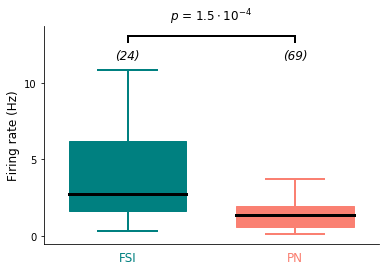

In [21]:
if "__file__" not in dir():
    plotBoxPLotFrateMSNVsFSI(dataArray=allFiringRatesPositiveModulation)

In [22]:
def plotHalfWithVspeakToValleyAccordingToClass(A,ax=None,markerSize=30):
    if ax is None:
        ax=plt.subplot()
    
    
    for groupIndex,unitIndexesPerGroup in enumerate(A):
        for unitIndex in unitIndexesPerGroup:
            unitSessionShankClu=allFiringRatesPositiveModulation[int(unitIndex)][-4:-1]
            halfWidth,peakToValley=GetHalfWidthPeakToValley(unitSessionShankClu[0],unitSessionShankClu[1],unitSessionShankClu[2])[:2]
            ax.scatter(halfWidth,peakToValley,color=colors[groupIndex],s=markerSize)

        ax.set_xlim(0,0.5)
        ax.set_ylim(0,1.6)
        
        #plt.axvline(0.2,color="k",linestyle="--")
        #plt.axhline(0.5,color="k",linestyle="--")
        #ax=plt.gca()
        ax.add_patch(Rectangle((0.05,0.1),0.15,0.355,fill=False,linestyle='--',ec='teal',lw=2))
        ax.add_patch(Rectangle((0.15,0.560),0.3,0.940,fill=False,linestyle='--',ec='salmon',lw=2))
        
        modifyAxesForFig(ax,"Half-width (ms)","Peak-to-valley (ms)")
        ax.yaxis.set_label_coords(-0.175,0.5)

In [23]:
#cellTypeToAnalyse=['MSN','salmon']

def showcellTypeInWaveformScatter(A,clu_quadraticFit,cellTypeToAnalyse=['MSN','salmon']):
    waveFormLimits={"cellType":["FSI","MSN"],"halfWidth":[[.050,.200],[.150,.450]],"peakToValley":[[.100,.450],[.560,1.500]]}
    colors=["goldenrod","darkgreen","lightgreen","brown","lightblue","darkblue","gray"]
    for index,cellType in enumerate(waveFormLimits["cellType"]):
        if cellType is cellTypeToAnalyse[0]:
            cellTypeIndex=index

    halfWidthLimits=waveFormLimits["halfWidth"][cellTypeIndex]
    peakToValleyLimits=waveFormLimits["peakToValley"][cellTypeIndex]
    cellTypeCoef=[]
    cellTypeLabel=[]
    
    
    for groupIndex,cellIndexes in enumerate(A):
        for cellIndex in cellIndexes:
            #print(groupIndex,cellIndex)
            cellIndex=int(cellIndex)
            plt.plot(clu_quadraticFit[cellIndex][1],clu_quadraticFit[cellIndex][0],"o",color=colors[groupIndex])    
            UnitsInfo=allFiringRatesPositiveModulation[cellIndex][-4:-1]
            halfWidth,peakToValley=GetHalfWidthPeakToValley(UnitsInfo[0],UnitsInfo[1],UnitsInfo[2])[:2]
            if (halfWidthLimits[0] <= halfWidth <= halfWidthLimits[1]) and (peakToValleyLimits[0] <= peakToValley <= peakToValleyLimits[1]):
                plt.plot(clu_quadraticFit[cellIndex][1],clu_quadraticFit[cellIndex][0],"+",markersize=20,color=cellTypeToAnalyse[1])
                cellTypeCoef.append([clu_quadraticFit[cellIndex][1],clu_quadraticFit[cellIndex][0]])
                cellTypeLabel.append(groupIndex)
                
    return cellTypeCoef,cellTypeLabel

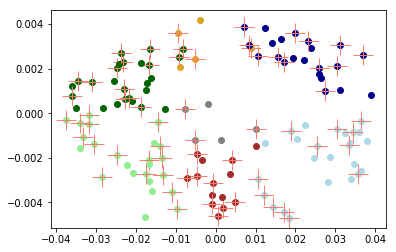

In [24]:
cellTypeCoef,cellTypeLabel=showcellTypeInWaveformScatter(A,clu_quadraticFit)

## Prepare the figure organization

In [25]:
topVSpace=0.055
bellowVSpace=0.1
leftHSpace=0.075
rightHSpace=0.975
betweenRowSpace=0.125
nRows=2
ratioRaws=[1,1]
vspaceForFig=1.0-(topVSpace+bellowVSpace+betweenRowSpace*(nRows-1))
#print("Total vertical space for figures: %s" %vspaceForFig)
topBottomLimits=[]
top=1
bottom=1
for rawNumber,rawRatio in enumerate(ratioRaws):
    vSpaceForRow=vspaceForFig*(rawRatio/np.sum(ratioRaws))
    print("raw %s size is %s" %(rawNumber+1, vSpaceForRow))
    if rawNumber==0:
        top-=topVSpace
        bottom-=topVSpace+vSpaceForRow
        print(top,bottom)
    else:
        top=bottom-betweenRowSpace
        bottom=top-vSpaceForRow
        print(top,bottom)
        print(rawNumber)
        if rawNumber==nRows-1:
            if np.round(bottom,2)!=np.round(bellowVSpace,2):
                print("last bottom does not match with required space")
    topBottomLimits.append([top,bottom])
print(topBottomLimits)        

raw 1 size is 0.36
0.945 0.585
raw 2 size is 0.36
0.45999999999999996 0.09999999999999998
1
[[0.945, 0.585], [0.45999999999999996, 0.09999999999999998]]


MOU025_2014_08_22_15_48
MOU101_2016_01_21_16_41
MOU025_2014_08_22_15_48
Preprocess behavior data loaded from /data/MOU025/Experiments/MOU025_2014_08_22_15_48/Analysis/preprocesseddata_binsize250ms_.p
Spike data loaded from /data/MOU025/Experiments/MOU025_2014_08_22_15_48/Analysis/rawspikedata.p
MOU101_2016_01_21_16_41
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/preprocesseddata_binsize250ms_.p
Spike data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/rawspikedata.p
(24)
(69)
1
[0.15, 0.45]
Silhouete score : 0.036986


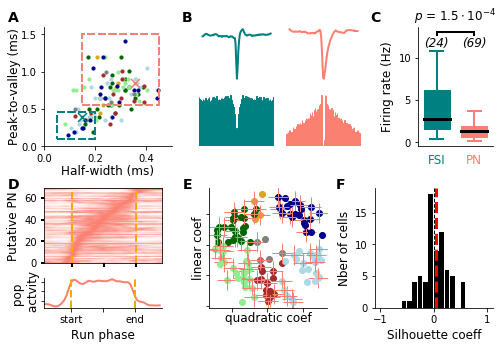

In [26]:
colors=["goldenrod","darkgreen","lightgreen","brown","lightblue","darkblue","gray"]
unitWaveFormCCGIlustrations=[['MOU025_2014_08_22_15_48', 2, 4],['MOU101_2016_01_21_16_41', 3, 47]]
nSideBin=12

fig=plt.figure(figsize=(cm2inch(17.6),cm2inch(17.6*2/3)))
for index,topBottomLimit in enumerate(topBottomLimits):
    if index==0:
        gs1 = gridspec.GridSpec(2,9)
        gs1.update(top=topBottomLimit[0],bottom=topBottomLimit[1],left=leftHSpace, right=rightHSpace, wspace=1.5,hspace=0.2)
        ax1 = plt.subplot(gs1[:, 0:3])
        plotHalfWithVspeakToValleyAccordingToClass(A,ax1,markerSize=10)
        ax1.xaxis.set_label_coords(0.5,-0.15)

        
        ax2=plt.subplot(gs1[0,3:5])
        ax3=plt.subplot(gs1[0,5:7])
        waveformValues=plotWaveFormIllustrations(unitWaveFormCCGIlustrations,['teal','salmon'],[ax2,ax3])
        
     
        
        ### show where are the two illustrative cells
        for waveformValue,thisColor in zip(waveformValues,['teal','salmon']):
            #ax1.scatter(waveformValue[0],waveformValue[1],marker='o',s=80,edgecolors=thisColor,facecolors='none')
            ax1.scatter(waveformValue[0],waveformValue[1],marker='x',s=80,color=thisColor)
        
        ax4=plt.subplot(gs1[1,3:5])
        ax5=plt.subplot(gs1[1,5:7])
        plotACGIllustrations(unitWaveFormCCGIlustrations,['teal','salmon'],[ax4,ax5])
        
        ax6=plt.subplot(gs1[:, -2:])
        plotBoxPLotFrateMSNVsFSI(dataArray=allFiringRatesPositiveModulation,ax=ax6)
#         ax6.boxplot([ValueMSN,ValueInterneuron],"")
#         ax6.set_xticklabels(["pMSN","pFSI"])
#         modifyAxesForFig(ax6,"","Firing rate (Hz)")

        for ax,switch in zip([ax2,ax4,ax3,ax5],[.01,.01,.05,.05]):
            pos=ax.get_position()
            pos.x1=pos.x1-switch
            pos.x0=pos.x0-switch
            ax.set_position(pos)
        
    else:
        gs1 = gridspec.GridSpec(3,3)
        gs1.update(top=topBottomLimit[0],bottom=topBottomLimit[1],left=leftHSpace, right=rightHSpace, wspace=0.4,hspace=0.5)
        
        
        ax1 = plt.subplot(gs1[0:2,0])
        fRateArray=makeFrateArrayBasedOnWaveform(waveFormLimits,allFiringRates,cellTypeToAnalyse="PN")
        rgbValues=getRGBFromName('salmon')
        cmap2 = CustomCmap([1.00, 1.00, 1.00], rgbValues)
        plotallcells(fRateArray,yLabel="Putative PN",postionXlabel='bottom',matriceColor=cmap2)
        ax1.yaxis.set_label_coords(-0.2,0.5)
        ax1.xaxis.label.set_visible(False)
        ax1.tick_params(labelbottom='off') 
        
        ax2=plt.subplot(gs1[2,0])
        ax2.plot(np.mean(fRateArray,axis=0),color='salmon',lw=2)
        modifyAxesForFig(ax2,"Run phase"," pop  \n actvity")
        ax2.set_xlim([0,fRateArray.shape[1]])
        ax2.axvline(nSideBin,color="orange",linestyle='--',linewidth=2)
        ax2.axvline(fRateArray.shape[1]-nSideBin,color="orange",linestyle='--',linewidth=2)
        ax2.set_xticks([nSideBin,fRateArray.shape[1]/2,fRateArray.shape[1]-nSideBin])
        ax2.set_xticklabels(["start","","end"])
        ax2.set_yticklabels([])
        ax2.tick_params(labelleft='off')
        #ax3.yaxis.set_label_coords(-0.2,0.5)
        
        ax3=plt.subplot(gs1[:,1]) #scatter
        cellTypeCoef,cellTypeLabel=showcellTypeInWaveformScatter(A,clu_quadraticFit)
        modifyAxesForFig(ax3,"quadratic coef","linear coef")
        ax3.tick_params(labelbottom='off',labelleft='off')
        
        
        silScore=metrics.silhouette_score(cellTypeCoef,cellTypeLabel)
        print('Silhouete score : %f' %silScore)
        silValues=metrics.silhouette_samples(cellTypeCoef,cellTypeLabel)
        ax4=plt.subplot(gs1[:,2]) # distri silh
        plot_distribution(silValues,[-1,1,0.1],["Nber of cells","Silhouette coeff"])
        ax4.axvline(silScore,color="red",linestyle='--',linewidth=3)
        ax4.axvline(0,color="k",linestyle='--',linewidth=1)
        
        
        
figuresLabels={"A":[0.025,0.95],"B":[0.3725,0.95],"C":[0.75,0.95],"D":[0.025,0.45],"E":[0.37295,0.45],"F":[0.68,0.45]}
for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0],coordinates[1],label,figure=fig,weight='bold',fontsize=14,ha='right' ,va='bottom')
saveFullName=os.path.join(savePath,'RevisedFigS04_CellType.pdf')
plt.savefig(saveFullName,orientation='landscape',dpi=600,format='pdf')  
        
       

**Figure S4. Population activity of putative projection neurons. A)** Scatter plot of two waveforms markers. Each dot represent a single neurons (same color code than Fig 5B). Dashed squares indicate classical limits used to distinguish putative fast spiking interneurons (FSI, teal) and projection neurons (PN, salmon). **B)**  Examples of waveforms (top) and spike auto-correlograms (bottom, 1 ms bin, +- 100 ms) of a putative FSI (teal) and putative PN (salmon). **C)**  Boxplot of average firing rates for putative FSI and PN during task performance. Statistical comparison was done using the non-paramatric Wilcoxon test. **D)**  Normalized average firing rates during run (sorted according to the peak firing rate phase) for putative PN (top) and averaged population firing rate activity (bottom). **E)** Similar than figure 5D with crosses indicating putative PN. **F)** Distribution of the silhouette coefficients for data points in E marked by cross (i.e., putative PN). Red dashed line indicates overall silhouette score.